In [19]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_runner
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dataclasses
import pandas as pd
import statsmodels.api as sm
import ISLP
import ISLP.models
import subprocess
import io
import shutil
import flg_diagnostics

In [2]:
res_dir = fls.result_dir + '/many_abbr_res/'
temp_dir = fls.temp_dir + '/temptemp/'
fls.remove_and_make_dir(res_dir)
fls.remove_and_make_dir(temp_dir)
fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated/', temp_dir)
shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)
fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated-2/', temp_dir)
shutil.copytree(temp_dir, res_dir, dirs_exist_ok=True)

'd:/flagellar/results//many_abbr_res/'

In [22]:
# Read results from vast.ai
files = glob.glob(res_dir + '*.pickle')
dicts = []
dicts_kaggle_comp = []
modifier_values_list = []
data_list = []
missing_values = dict()
for f in files:    
    print(f)
    data_list.append(fls.dill_load(f)    )
    #if not (data_list[-1].modifier_values['seed']>=5): print('skip'); continue
    modifier_values_list.append(data_list[-1].modifier_values)
    #print(modifier_values_list[-1])
    for key,value in data_list[-1].modifier_dict.items():
        missing_values[key] = value.missing_value
    #print(modifier_values_list[-1])

d:/flagellar/results//many_abbr_res\Baseline_0_dbb9ae99_842 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1000_dbb9ae99_818 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1001_dbb9ae99_876 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1002_dbb9ae99_921 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1003_dbb9ae99_861 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1004_dbb9ae99_887 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1005_dbb9ae99_850 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1006_dbb9ae99_855 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1007_dbb9ae99_877 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1_dbb9ae99_860 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_2_dbb9ae99_920 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_3_dbb9ae99_935 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_4_dbb9ae99_925 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_5_dbb9ae99_915 _a.pic

In [28]:
for data, modifier_values in zip(data_list, modifier_values_list):

    d = copy.deepcopy(missing_values)
    #print(modifier_values)
    for key,value in modifier_values.items():
        d[key] = value
        #print(d)
    #d['lr0_times_nepochs'] = d['lr0']*d['n_epochs']
    #print(d)
    #raise 'stop'
    # if predict_all:
    #     data.trained_model.data_after_step2 = data.inferred_test_data     
    #     data.trained_model.step3Output.threshold=-1
    #     data.inferred_test_data = data.trained_model.infer(data.test_data)
        
    d['label'] = data.label
    d['git_commit_id'] = data.git_commit_id
    d['use_missing_value'] = data.use_missing_value

    # Reinfer
    

    # false_conf = []
    # true_conf = []
    # for dd,r in zip(data.inferred_test_data, data.test_data):
    #     if len(r.labels)>0:
    #         true_conf.append(dd.labels['confidence'][0])
    #     else:
    #         false_conf.append(dd.labels['confidence'][0])
    # plt.figure()
    # plt.hist(true_conf,alpha=0.5)
    # plt.hist(false_conf,alpha=0.5)

    dat, test_data = flg_diagnostics.expand_and_reinfer(data.inferred_test_data, data.test_data, data.untrained_model.step3Output.select_motors, 0.7)
    d['cv_score'] = fls.score_competition_metric(dat, test_data)[2]
    print(d['cv_score'])

    d_kaggle_comp = dict()
    d_kaggle_comp['label'] = data.label
    d_kaggle_comp['git_commit_id'] = d['git_commit_id']
    d_kaggle_comp['use_missing_value'] = d['use_missing_value']
    d_kaggle_comp['seed'] = d['seed']   
    d_kaggle_comp['cv_score'] = d['cv_score']
    d_kaggle_comp['k_score'] = np.nan

    print(len(data.test_data))

    dicts_kaggle_comp.append(d_kaggle_comp)

    # First set
    #if not (d['seed']<26 or d['use_missing_value']): print('skip'); continue

    # New
    #if not (d['seed']>=26 or d['use_missing_value']): print('skip'); continue
    #if d['label']=='Test ensemble': continue

    
    
    
    for partial in fls.DataSelector().datasets:
        data_selector = fls.DataSelector()
        data_selector.datasets = [partial]
        d['cv_score_' + partial] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]

    data_selector = fls.DataSelector()
    data_selector.datasets = ['ycw', 'mba', 'aba']
    d['cv_score_other'] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]
    
    d['k_score']= np.nan

    dicts.append(d)    
p = pd.DataFrame(dicts)
p.sort_values(['seed', 'git_commit_id'], inplace=True);

p_kaggle_comp = pd.DataFrame(dicts_kaggle_comp)
p_kaggle_comp.sort_values(['seed', 'git_commit_id'], inplace=True);

# First set
# p = p[np.logical_or(p['seed']<26, p['use_missing_value'])]

# New
#p = p[np.logical_or(p['seed']>=26, p['use_missing_value'])]

p = p.reset_index()
p_kaggle_comp = p_kaggle_comp.reset_index()

0.6445993031358885
230
0.6426056338028169
230
0.7354221061792864
230
0.840630472854641
230
0.7055214723926381
230
0.7456140350877193
230
0.680628272251309
230
0.7092819614711033
230
0.6617002629272568
230
0.7017543859649122
230
0.818815331010453
230
0.840630472854641
230
0.8333333333333334
230
0.8224543080939948
230


In [29]:
# Load Kaggle results
#if predict_all:
#    kaggle_results_file = fls.code_dir + '../kaggle_results_predict_all.csv'
#else:
kaggle_results_file = fls.code_dir + '../kaggle_results.csv'
p_kaggle_results = pd.read_csv(kaggle_results_file).reset_index()

In [30]:
# Add competition results
csv = subprocess.run('kaggle competitions submissions -q -csv -c byu-locating-bacterial-flagellar-motors-2025', encoding = 'utf-8', shell=True, stdout=subprocess.PIPE)
lines = csv.stdout.split('\n')[1:]
data_str = "\n".join(lines)
p_submissions = pd.read_fwf(io.StringIO(data_str), skiprows=[1])
for i_i in range(len(p_kaggle_results)):
    mv_str = 'Ma' if p_kaggle_results.loc[i_i, 'use_missing_value'] else ''
    name_str = p_kaggle_results.loc[i_i, 'label'] + '_' + str(p_kaggle_results.loc[i_i, 'seed']) + mv_str + '_' + p_kaggle_results.loc[i_i, 'git_commit_id'][:8]
    #if predict_all:
    #    name_str = name_str + ' predict all'
    for i_k in range(len(p_submissions)):
        if name_str == p_submissions.loc[i_k, 'description']:
            score = p_submissions.loc[i_k, 'publicScore']
            if not np.isnan(score):
                if np.isnan(p_kaggle_results.loc[i_i, 'k_score']):
                    p_kaggle_results.loc[i_i, 'k_score'] = score
                    print(f'Added score of {score:1.3} for {name_str}')
                else:
                    if not score == p_kaggle_results.loc[i_i, 'k_score']:
                        raise Exception(f'Mismatch for {name_str}: {score:1.3} vs {p_kaggle_results.loc[i_i, "k_score"]:1.3}')
            else:
                print('NaN score found for ', name_str)            
            break

In [31]:
#print(p_kaggle_results)
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p_kaggle_comp)):
        if p_kaggle_results['seed'][i_k] == p_kaggle_comp['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p_kaggle_comp['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p_kaggle_comp['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p_kaggle_comp['label'][i_i]:
            p_kaggle_comp.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p)):
        if p_kaggle_results['seed'][i_k] == p['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p['label'][i_i]:
            p.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]

In [32]:
# Write results to Kaggle results file
p_kaggle_cache = copy.deepcopy(p_kaggle_comp[['label', 'git_commit_id', 'use_missing_value', 'seed', 'cv_score', 'k_score']])
p_kaggle_cache.to_csv(kaggle_results_file)

In [33]:
p.to_csv(fls.code_dir + '../results.csv')
p

,index,n_ensemble,n_epochs,use_best_epoch,extra_data,trust_neg,model_name,seed,label,git_commit_id,use_missing_value,cv_score,cv_score_tom,cv_score_other,k_score
0,0,3,56,False,False,-1,yolov8s,0,Baseline,dbb9ae992ef43f57f706671bb545111a69cea932,False,0.644599,0.875000,0.938303,0.761
1,9,1,50,True,False,1,yolov8l,1,Baseline,dbb9ae992ef43f57f706671bb545111a69cea932,False,0.701754,0.857741,0.943517,NaN
2,10,3,40,False,True,0,yolov8s,2,Baseline,dbb9ae992ef43f57f706671bb545111a69cea932,False,0.818815,0.857741,0.984752,NaN
3,11,3,33,False,True,1,yolov8m,3,Baseline,dbb9ae992ef43f57f706671bb545111a69cea932,False,0.840630,0.857741,0.984752,NaN
4,12,3,68,True,True,1,yolov8s,4,Baseline,dbb9ae992ef43f57f706671bb545111a69cea932,False,0.833333,0.857741,0.994930,NaN
5,13,3,63,True,True,0,yolov8s,5,Baseline,dbb9ae992ef43f57f706671bb545111a69cea932,False,0.822454,0.857741,1.000000,NaN
6,1,1,51,True,False,-1,yolov8s,1000,Baseline,dbb9ae992ef43f57f706671bb545111a69cea932,False,0.642606,0.857741,0.933076,NaN
7,2,3,55,False,False,1,yolov8l,1001,Baseline,dbb9ae992ef43f57f706671bb545111a69cea932,False,0.735422,0.875000,0.953905,NaN
8,3,3,45,False,True,0,yolov8m,1002,Baseline,dbb9ae992ef43f57f706671bb545111a69cea932,False,0.840630,0.857741,0.989848,0.788
9,4,1,37,False,False,1,yolov8m,1003,Baseline,dbb9ae992ef43f57f706671bb545111a69cea932,False,0.705521,0.840336,0.943517,NaN


In [34]:
to_plot = copy.deepcopy(p).columns.to_list()[1:-8]
main = np.logical_and(np.logical_not(p['use_missing_value']), np.logical_not(p['cv_score']==-1.))
#print(main)
#print(p['model_name']=='yolov8m')
#main = p['tom']
# for x_val in ['cv_score', 'cv_score_tom', 'cv_score_ycw', 'cv_score_aba', 'cv_score_mba']:
#      plt.figure()
#      plt.scatter(p[x_val][main], p['k_score'][main])
#      plt.grid(True)
#      plt.xlabel(x_val)
#      plt.ylabel('Kaggle score')
to_plot

['n_ensemble',
 'n_epochs',
 'use_best_epoch',
 'extra_data',
 'trust_neg',
 'model_name']

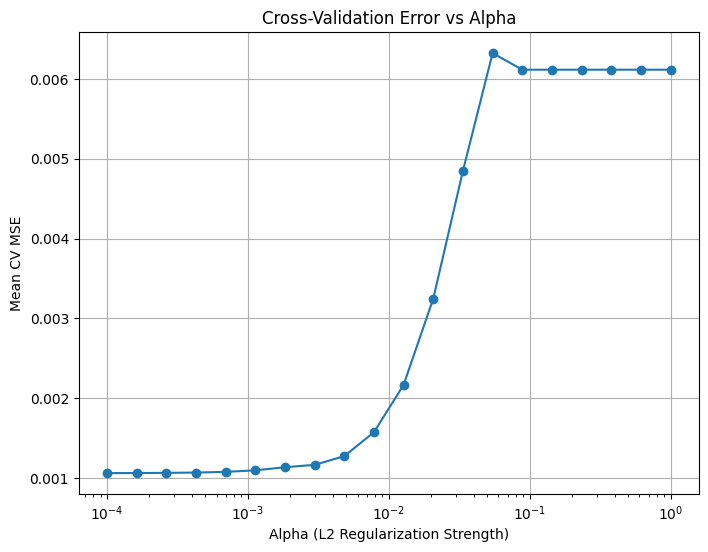

Best alpha (lambda): 0.0001
Best CV Mean MSE: 0.0010632466675210785
Final coefficients: [ 0.04481386  0.03716069 -0.00882686  0.01282174  0.00813066 -0.01890704]
Final intercept: [0.74164224]
0.00019991396771666035
cv_score    0.005273
dtype: float64


C:\Users\jeroe\anaconda3\envs\jupyterlab-debugger2\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline

todo = np.logical_and(main, np.logical_not(np.isnan(p['cv_score'].to_numpy())))
y = p[['cv_score']][todo]
X = p[['extra_data', 'trust_neg', 'n_ensemble', 'use_best_epoch', 'n_epochs']][todo]
X = p[['extra_data', 'trust_neg', 'use_best_epoch', 'n_ensemble', 'n_epochs']][todo]
X['trust_neg2'] = X['trust_neg']**2
#X['yolov8m'] = (p['model_name']=='yolov8m')
#X['scale_std_clip_value2'] = X['scale_std_clip_value']**2
#X['lr0_times_nepochs2'] = X['lr0_times_nepochs']**2
#X = X[['extra_data']]

# Define candidate alphas (lambdas)
alphas = np.logspace(-4, 0, 20)

# Define pipeline explicitly with named steps
pipeline = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("ridge", sklearn.linear_model.Lasso())
])

# Define parameter grid (for Ridge alpha)
param_grid = {
    "ridge__alpha": alphas
}

# GridSearchCV with 5-fold cross-validation
grid_search = sklearn.model_selection.GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=len(y),
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(X, y)

# Extract results
results = grid_search.cv_results_
mean_test_scores = -results['mean_test_score']  # Convert to positive MSE
alphas_tested = results['param_ridge__alpha'].data.astype(float)

# Plot CV error as function of alpha
plt.figure(figsize=(8, 6))
plt.semilogx(alphas_tested, mean_test_scores, marker='o')
plt.xlabel("Alpha (L2 Regularization Strength)")
plt.ylabel("Mean CV MSE")
plt.title("Cross-Validation Error vs Alpha")
plt.grid(True)
plt.show()

# Report best alpha
best_alpha = grid_search.best_params_['ridge__alpha']
print("Best alpha (lambda):", best_alpha)
print("Best CV Mean MSE:", -grid_search.best_score_)

# Create a new pipeline with the best alpha
final_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("lasso", sklearn.linear_model.Lasso(alpha=best_alpha))
])

# Fit to full dataset
final_model.fit(X, y)

y_pred = final_model.predict(X)
p['residual'] = np.nan
#p.loc[todo,'residual'] = (y-y_pred).to_numpy()
p.loc[todo,'residual'] = (np.ravel(y)-y_pred)

# (Optional) Print final coefficients and intercept
lasso_model = final_model.named_steps['lasso']
print("Final coefficients:", lasso_model.coef_)
print("Final intercept:", lasso_model.intercept_)

print(np.std(p['residual'][todo])**2)
print(np.std(y[todo])**2)

In [17]:
# X_alt = copy.deepcopy(X)
# for c in X_alt.columns:
#     X_alt[c] = 0
# X_alt['lr0_times_nepochs'] = X['lr0_times_nepochs']
# X_alt['lr0_times_nepochs2'] = X['lr0_times_nepochs']**2
# y_pred_alt = final_model.predict(X_alt)
# plt.scatter(X_alt['lr0_times_nepochs'], y_pred_alt)

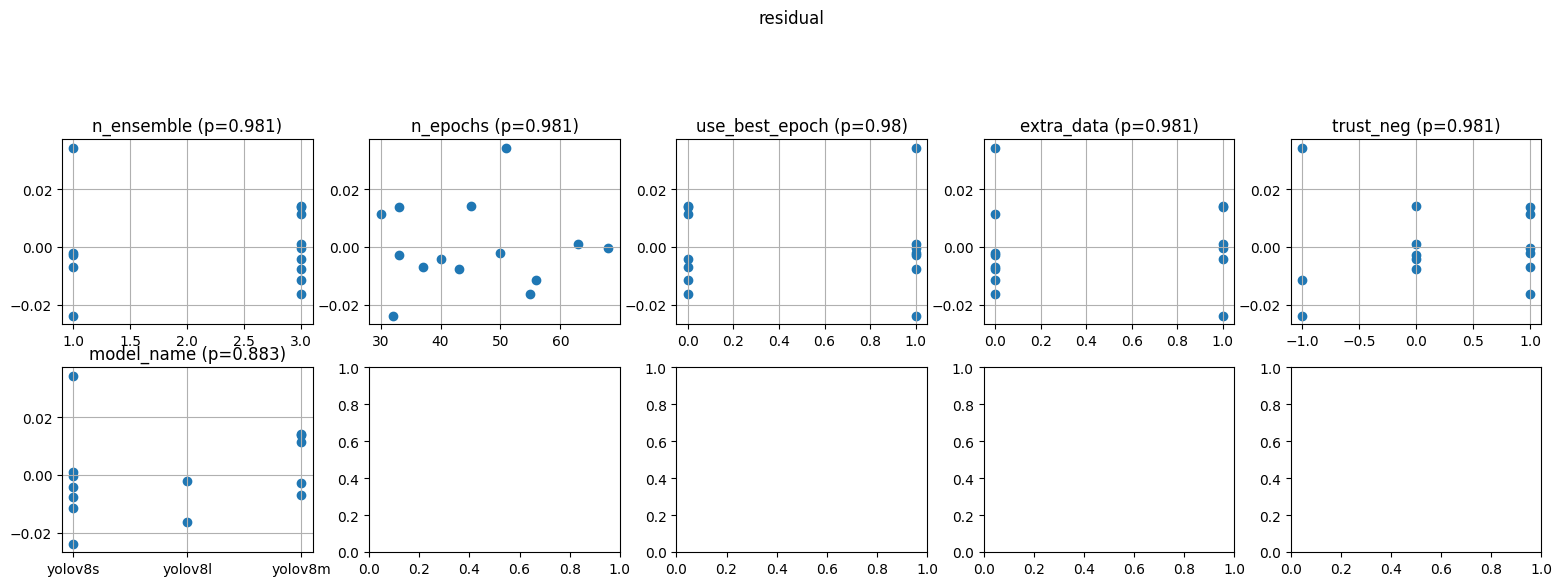

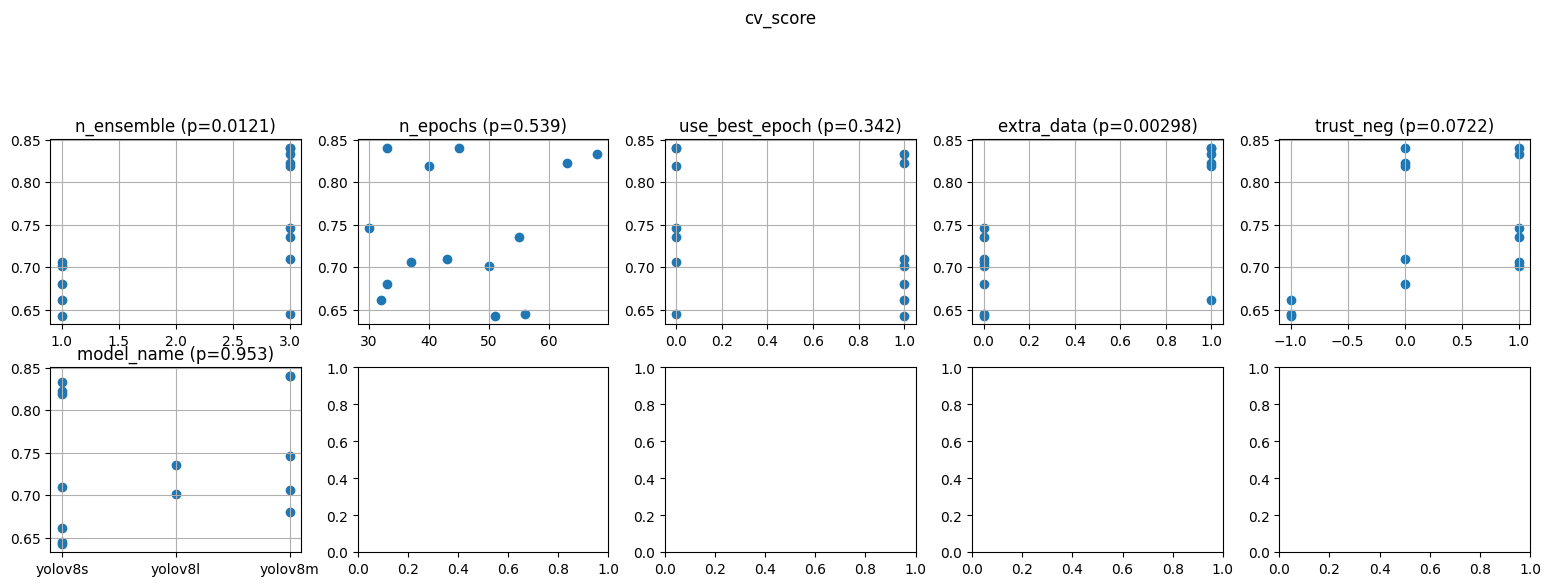

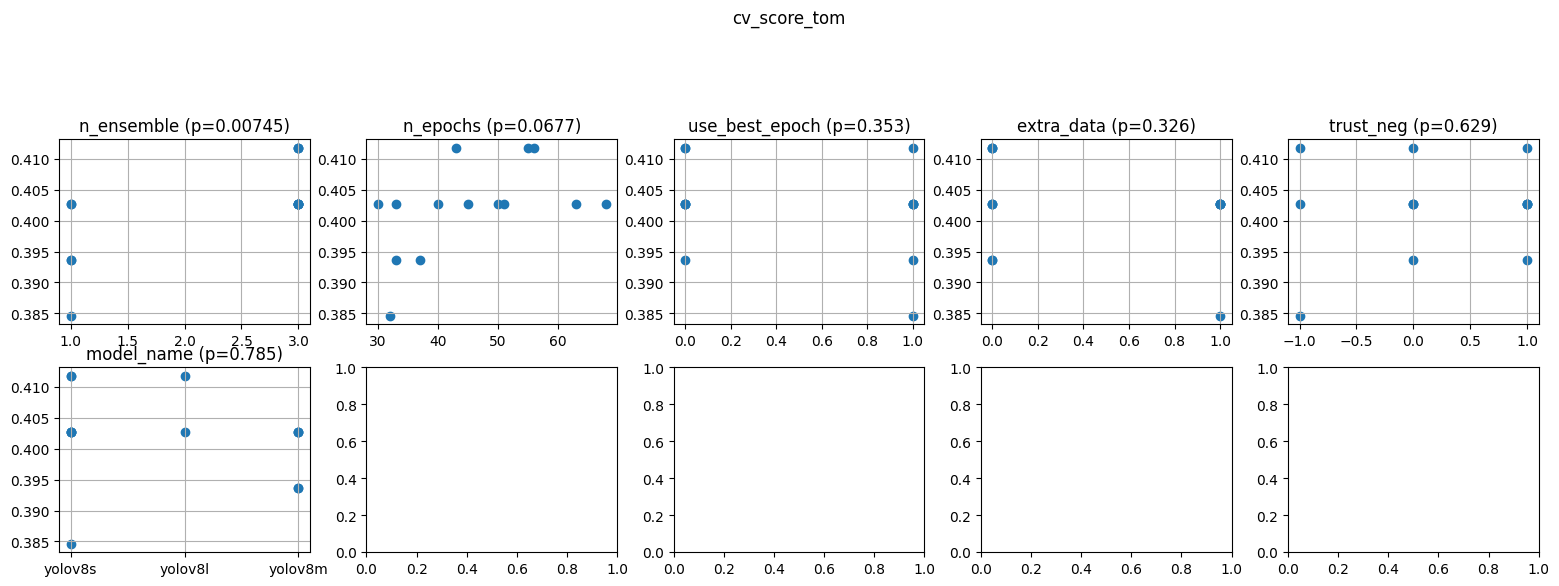

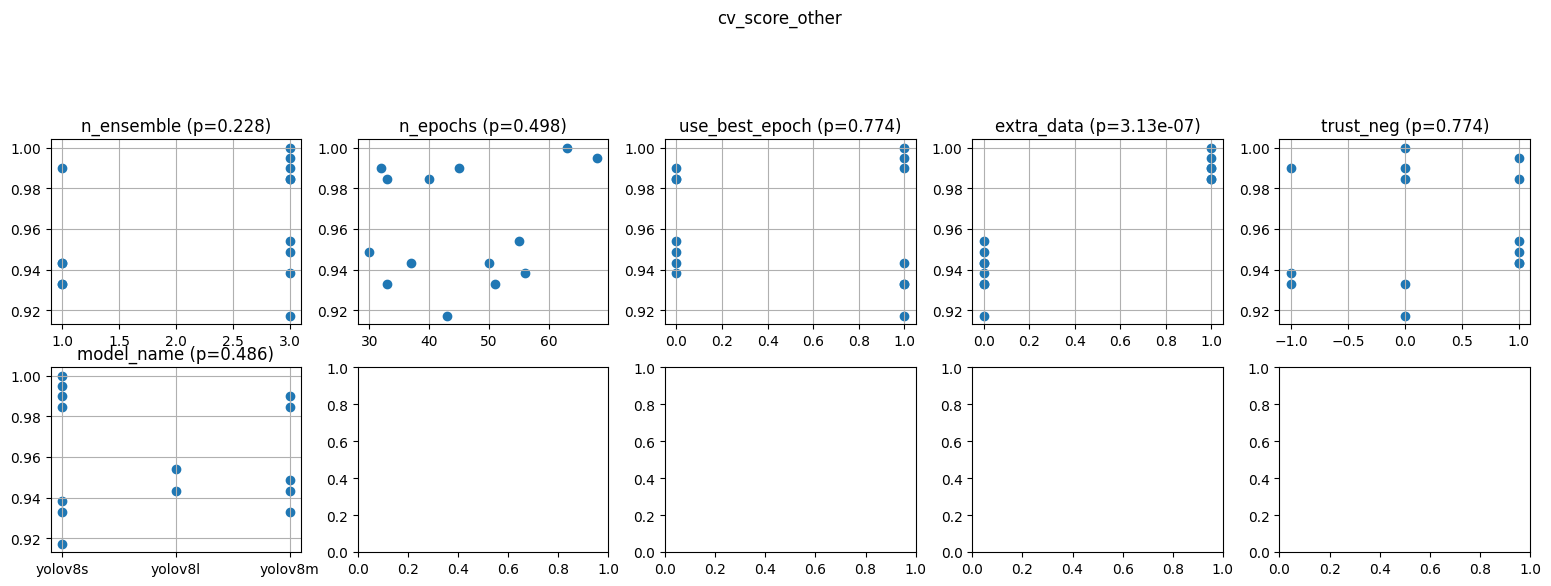

In [18]:
ncols = 5
nrows = len(to_plot)//ncols+1
figs = []
r = np.random.default_rng(seed=0)
for y_val in p.columns[[-1,-5,-4,-3]].to_list():
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18/ncols*nrows))
    plt.tight_layout(pad=10.0,h_pad=1,w_pad=1)
    figs.append(fig)
    plt.suptitle(y_val)
    for idx,d in enumerate(to_plot):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]
        plt.sca(ax)        
        plt.xlabel('')
        plt.ylabel('')
        plt.grid(True)
        #p[y_val] = r.normal(size=p[y_val].shape)
        plt.scatter(p[d][main], p[y_val][main])
        #if y_val == 'k_score':
         #   plt.scatter(p[d][np.logical_not(main)], p[y_val][np.logical_not(main)])
       
        # fit
        if len(np.unique(p[d][main]))>1:
            pp = copy.deepcopy(p)
            if not pd.api.types.is_numeric_dtype(pp[d]) or pd.api.types.is_bool_dtype(pp[d]):
                pp[d] = pp[d].astype('category').cat.codes
            X = pp[[d]][main]
            X['intercept'] = 1.
            y = p[y_val][main]
            to_keep = np.logical_not(np.isnan(y))
            X = X[to_keep]; y=y[to_keep];
            model = sm.OLS(y,X)
            results=model.fit()
            p_val = results.pvalues[d]
            plt.title(f'{d} (p={p_val:.3})')
        else:
            plt.title(d)
        
        # if d == 'mask_sizes0':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][0] for m in model_list]
        # elif d == 'mask_sizes1':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][1] for m in model_list]
        # elif d == 'mask_sizes2':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][2] for m in model_list]
        # else:
        #     x_vals = [getattr(m, d)[model.particles_to_do[0]] for m in model_list]
        # if len(np.unique(x_vals))<8:
        #     #pass
        #     violin_plot(x_vals,score_vals)
        # else:
        #     plt.scatter(x_vals, score_vals)

In [13]:
# from pptx import Presentation
# from pptx.util import Inches

# prs = Presentation()
# blank = prs.slide_layouts[6]  # a blank slide layout

# for i, fig in enumerate(figs):
#     # save each figure to disk
#     img_path = f"figure_{i+1}.png"
#     fig.savefig(img_path, dpi=300, bbox_inches='tight')

#     # add a new slide, then add the image to it
#     slide = prs.slides.add_slide(blank)
#     slide.shapes.add_picture(
#         img_path,
#         Inches(1), Inches(1),          # left, top margins
#         width=Inches(8)                # scale width (height auto)
#     )

#     os.remove(img_path)

# prs.save("run_many_models_results.pptx")